In [1]:
import time
start_time=time.time()

In [2]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import json
import cmasher as cmr
import seaborn as sns
import sys

from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u

from turbustat.simulator import make_ppv
from turb_utils import make_extended, make_3dfield

from spectral_cube import SpectralCube  



3D maps

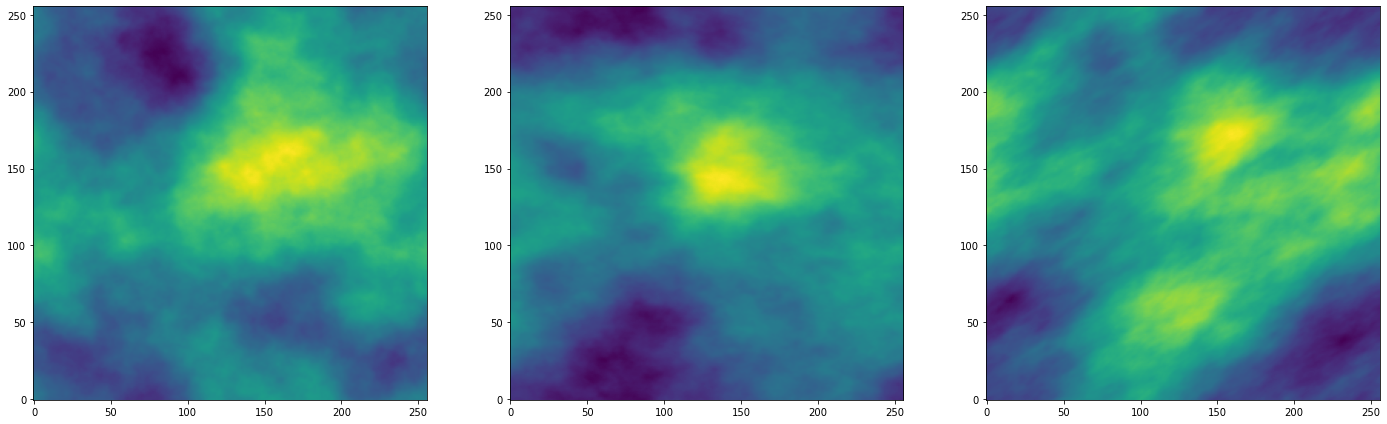

In [3]:
r0 = 32.0
N = 256
m = 1.0

threeD_field = make_3dfield(
    N,
    ellip=0.5,
    theta=45,
    powerlaw=3.0 + m,
    randomseed=2021_10_08)

plt.figure(figsize=[20, 6])  
plt.subplot(131)  
plt.imshow(threeD_field.mean(0), origin='lower')  
plt.subplot(132)  
plt.imshow(threeD_field.mean(1), origin='lower')  
plt.subplot(133)  
plt.imshow(threeD_field.mean(2), origin='lower')  
plt.tight_layout()  

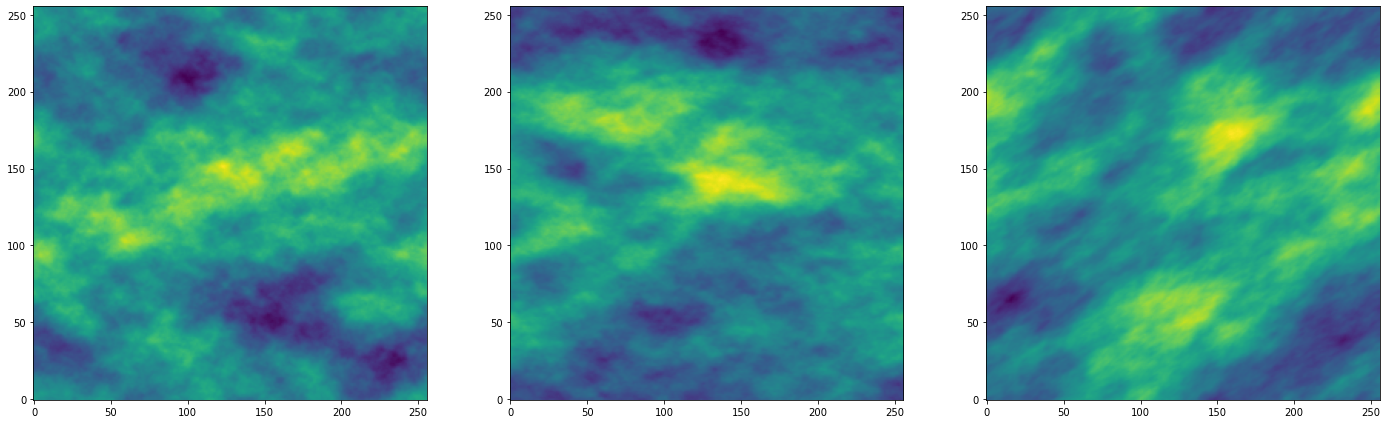

In [4]:
threeD_field = make_3dfield(
    N,
    ellip=0.5,
    theta=45,
    correlation_length=r0,  
    powerlaw=3.0 + m,
    randomseed=2021_10_08)

plt.figure(figsize=[20, 6])  
plt.subplot(131)  
plt.imshow(threeD_field.mean(0), origin='lower')  
plt.subplot(132)  
plt.imshow(threeD_field.mean(1), origin='lower')  
plt.subplot(133)  
plt.imshow(threeD_field.mean(2), origin='lower')  
plt.tight_layout()  

PPV

In [5]:
velocity = make_3dfield(
    N,
    ellip=0.5,
    theta=45,
    correlation_length=r0,  
    powerlaw=3.0 + m,
    randomseed=2021_10_08)* u.km / u.s  

density = np.ones((N,N,N))* u.cm**-3  
#density = make_3dfield(N, powerlaw=3.0 + m, amp=1.,randomseed=328764) * u.cm**-3  

In [6]:
density += density.std()  
density[density.value < 0.] = 0. * u.cm**-3  

In [7]:
cube_hdu = make_ppv(velocity, density, los_axis=0,
                    T=10000 * u.K, chan_width=0.5 * u.km / u.s,
                    v_min=-20 * u.km / u.s,
                    v_max=20 * u.km / u.s)  

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)


In [8]:
from spectral_cube import SpectralCube  
cube = SpectralCube.read(cube_hdu)  

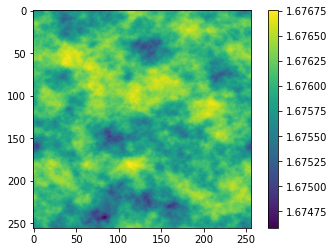

In [9]:
cube.moment0().quicklook()  
plt.colorbar()  

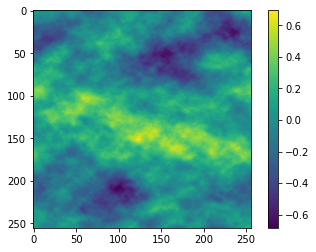

In [10]:
cube.moment1().quicklook()  
plt.colorbar()  

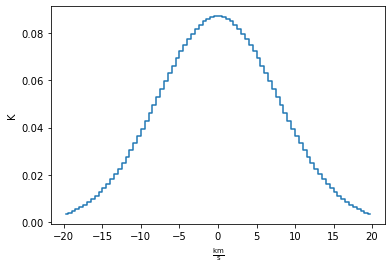

In [11]:
cube.mean(axis=(1, 2)).quicklook()  

In [12]:
print(cube)

SpectralCube with shape=(80, 256, 256) and unit=K:
 n_x:    256  type_x: GLON-CAR  unit_x: deg    range:     2.116667 deg:  357.866667 deg
 n_y:    256  type_y: GLAT-CAR  unit_y: deg    range:    -2.116667 deg:    2.133333 deg
 n_s:     80  type_s: VRAD      unit_s: km / s  range:      -19.750 km / s:      19.750 km / s


In [13]:
!jupyter nbconvert --to script --no-prompt fake-3d-tapered-maps.ipynb

[NbConvertApp] Converting notebook fake-3d-tapered-maps.ipynb to script
[NbConvertApp] Writing 2235 bytes to fake-3d-tapered-maps.py


In [14]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 222.65797448158264 seconds ---
